In [2]:
import sys
path ="/home/sergio/github/shaolin-master"
sys.path.append(path)

In [23]:
#wide screen hack, great for making big plots and have more room for the control panels
from IPython.core.display import HTML
html ='''
<style>
.container { width:100% !important; }
.input{ width:60% !important;
       align: center;
      }
.text_cell{ width:70% !important;
            font-size: 16px;}
.title {align:center !important;}
</style>'''
HTML(html)

# Shaolin GraphCalculator tutorial

<a id='index'></a>

## Index

- [1 Introduction](#intro)
- [2 Loading the sample data](#sample_data)
    - [2.1 Calculating the graph matrices](#sample_matrices)
    - [2.2 Calculating some metrics for the nodes](sample_node_metrics)
- [3 GraphCalculator componenets](#components)
   - [3.1 Graph creation parameters](#gc_parameters)
   - [3.2 Matrix transformations](#matrix_transforms)
   - [3.3 Graph layout](#graph_layout)

- [4 GraphCalculator data](#data)
   - [4.1 Node graph metrics](#node_metrics)
   - [4.2 Edge metrics](#edge_metrics)
   - [4.3 External node metrics](#external_node)
   - [4.4 Networkx Graph](#networkx_graph)

<a id='introduction'></a>

# 1 Introduction

In this tutorial we will analyse the structure of the graph resulting from the correlation matrix of the prices of different currency exchanges. We just need time series data and a few lines of code to map matrices into graphs and calculate its metrics.

<a id='sample_data'></a>

# 2 Loading the sample data

[Back to top](#index)

We are using a week of hourly data data from different to conduct our analysis. Each time series has also its normalized price, its returns and its logarithmic returns so you don't have to calculate it if you want to use it. In this example we will start just with the normalized price values.

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import Image #this is for displaying the widgets in the github repo
from shaolin.dashboards.graph import GraphCalculator
forex_data = pd.read_hdf('gcalculator_data/forex_sample.h5')
forex_data.items,forex_data.minor_axis,forex_data.major_axis

In [25]:
fund = forex_data['fund']
fund.head()

,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCAD,USDCHF,USDJPY
2016-02-15 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2016-02-15 01:00:00,1.000956,0.998559,1.001034,1.001826,0.998471,1.000491,1.001224
2016-02-15 02:00:00,1.001238,0.999502,1.000462,1.001267,0.998153,0.999530,0.997675
2016-02-15 03:00:00,1.003418,0.998514,1.000600,1.001750,0.997417,1.000726,1.000643
2016-02-15 04:00:00,1.004810,0.997972,1.000489,1.002882,0.996746,1.001615,1.002307


<a id='sample_matrices'></a>

## 2.1 Calculating the graph matrices

[Back to top](#index)

In this case we will start calculating the correlation and covariance matrices of the series.

In [6]:
matrices = {}
matrices['corr'] = fund.corr()
matrices['cov'] = fund.cov()
matrices['exchange'] = fund.corr()#alpha version hack, needs to be a matrix called exchange. you dont
                                  #need to use it
matrix_panel = pd.Panel(matrices)

In [26]:
matrix_panel

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 7 (major_axis) x 7 (minor_axis)
Items axis: corr to exchange
Major_axis axis: AUDUSD to USDJPY
Minor_axis axis: AUDUSD to USDJPY

<a id='sample_node_metrics'></a>

## 2.2 Calculating some metrics for the nodes

[Back to top](#index)

This data will be used to add additional information to every node of the graph. This information will be included in the GraphCalculator.

In [8]:
def calculate_pdf(x,n=1000):
        """Fits a Gaussian Kernel, resamples n values and returns (X,p(x=X))"""
        
        try:
            kernel = stats.gaussian_kde(x,bw_method='scott')
            X= kernel.resample(n)
            p = kernel(X)
        except:
            X= x
            p = np.ones(len(x))*1.0/len(x)
        return X.flatten(),p.flatten()

def shannon_entropy(x,n=1000):
    X,p = calculate_pdf(x,n)
    ent = p*np.log2(p)
    return -ent.sum()/(10*n)# this way we dont get values too big. 
                            #After all, entropy is a purely arbitrary measure ;)

def mean_rets(x):
     return x.pct_change().mean()*10e4

def std_rets(x):
     return x.pct_change().mean()*10e4
    
def total_rets(x):
    return x.pct_change().sum()

In [9]:
node_metrics = pd.DataFrame(columns=fund.columns)
funcs = [total_rets, np.mean, np.std, shannon_entropy,mean_rets,std_rets]
for fun in funcs:
    node_metrics.ix[fun.__name__] = fund.apply(fun)

In [10]:
node_metrics

,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCAD,USDCHF,USDJPY
total_rets,0.044782,-0.004359,-0.015000,0.005178,-0.034737,0.005485,-0.006254
mean,1.019019,0.980220,0.975572,1.007091,0.978751,1.015520,0.997831
std,0.018122,0.008516,0.012586,0.010881,0.013711,0.004247,0.006199
shannon_entropy,-10.101042,-17.269426,-10.302946,-15.579892,-9.508544,-42.435164,-26.678195
mean_rets,7.526429,-0.732642,-2.520989,0.870311,-5.838132,0.921772,-1.051116
std_rets,7.526429,-0.732642,-2.520989,0.870311,-5.838132,0.921772,-1.051116


<a id='components'></a>

# 3 GraphCalculator components

[Back to top](#index)

The GraphCalculator lets us have complete control over the process of turning a matrix and arbitrary data into a graph. Although every component can be used as a standalone widget it is recommended to use the *widget* attribute for controlling the GraphCalculator.

Every component can be hidden with the toggle buttons situated at the bottom, and every change you make in the widget will take effect after you click the Calculate button.

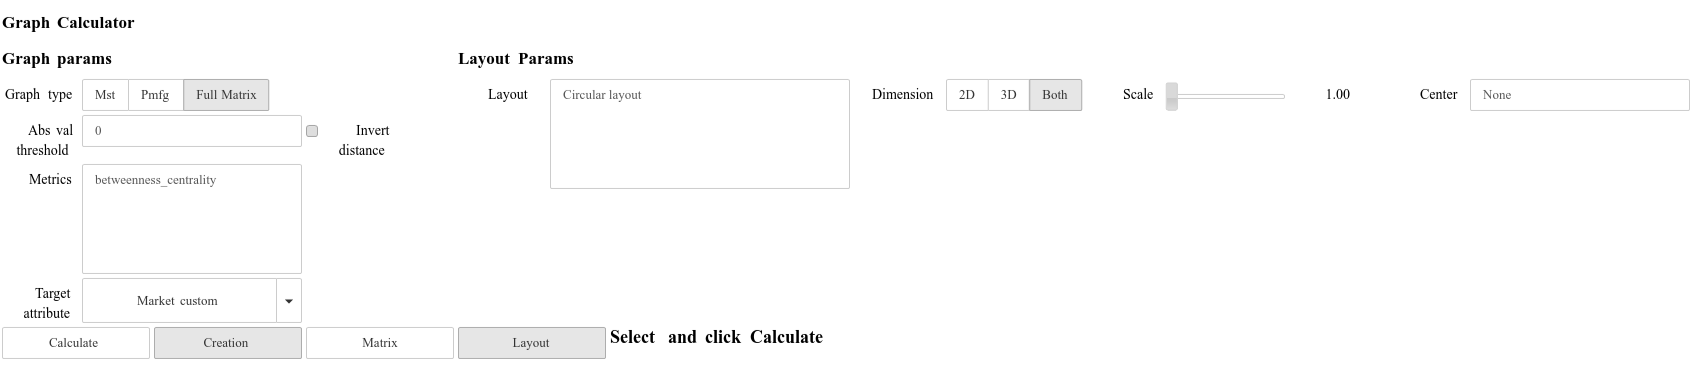

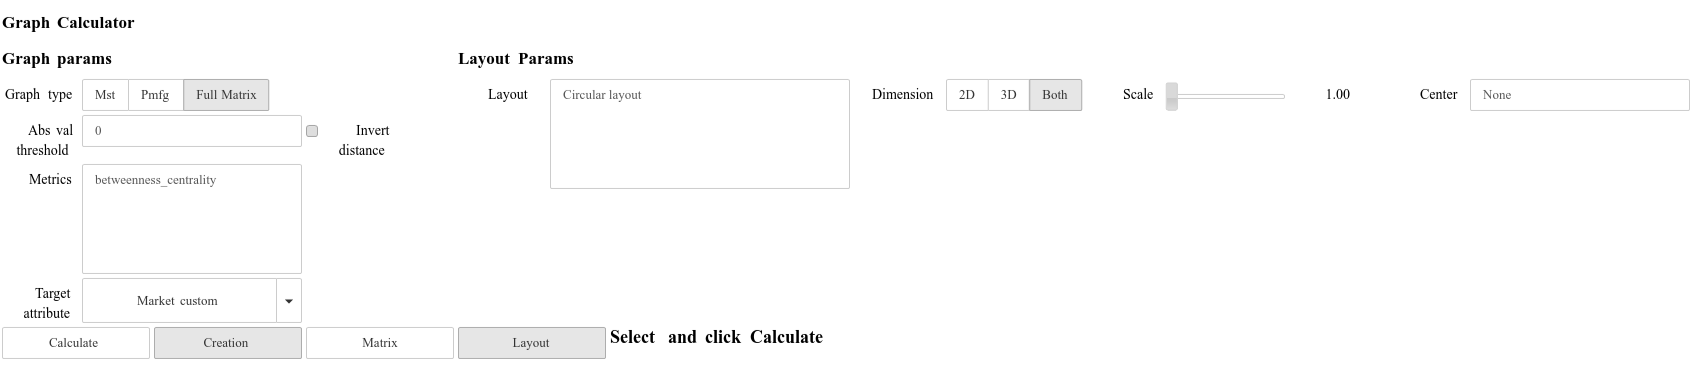

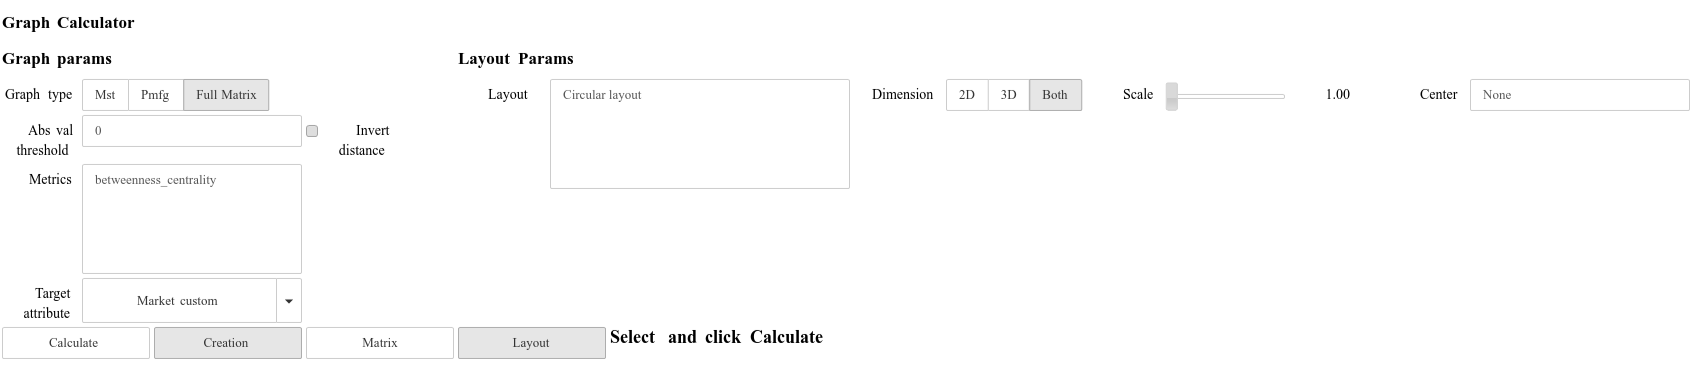

In [11]:
gc = GraphCalculator(node_metrics=node_metrics,matrix_panel=matrix_panel)
#Image(filename='gcalculator_data/widget.png') 
gc.widget

<a id='gc_parameters'></a>

## 3.1 Graph creation parameters

[Back to top](#index)

This widget is used to select which kind of graph will be calculated from the supplied matrix.

<img src='gcalculator_data/creation.png' style="height: 450px;"></img>

### Graph type

This is how the matrix will be converted into a graph. There are currently three possible options to build a non directed graph:

- **Full matrix**: The matrix will be interpreted as the adjacency matrix of a full connected graph.

- **MST**: The target graph will be a minimum spanning tree constructed and the data matrix.

- **PMFG**: Maximum planary filtered graph, calculated from the data matrix.

### Absolute value threshold

Minimum absolute value forn an element of the matrix needed to be taken into account as a valid edge.

### Invert distance

Use 1/value instead of the original value of the data matrix.

### Metrics



Node metrics that will be calculated when the graph is constructed

### Target attribute

This widget allows us to select which matrix of our matrix panel will be used as an adjacency matrix for the graph. In other words, this will select which data matrix we will convert into a graph.

<a id='matrix_transforms'></a>

## 3.2 Matrix transformations

[Back to top](#index)

This widget handles the transformations we will apply to the target data matrix before mapping it into a graph. One, or a succession of the following transformations has to be applied to the matrix.

- **Raw**: Do not apply any transformation.<br>

- **Scale**: Rescale the values of the matrix to match the interval [Rescale min, Rescale max].<br>

- **Clip**: All the values lower than Clip min will be changed for Clip min and all the values greater than Clip          max will be changed for Clip max.<br>

- **Zscore**: The matrix will be transformed so its elements have mean 0 and a standard deviation of 1.
- **Distance**: The matrix will be transformed according to the following distance function: 

<img src='gcalculator_data/matrix.png' style="height: 450px;"></img>

<a id='graph_layout'></a>

## 3.3 Graph Layout

[Back to top](#index)

<img src='gcalculator_data/layout.png' style="height: 300px;"></img>

The Layout manager is the widget in charge of managing the layout that we will use to draw our graph. It can calculate the layouts of the selected type. Any layout available in the networkx package is included in the LayoutCalculator and any of its parametrs can be tweaked via a widget.

**Alpha version disclaimer**: 
- Can only calculate both the 3D and the 2D and not only one of them separatedly.

<a id='data'></a>

# 4 GraphCalculator Data

[Back to top](#index)

The results of running the GraphCalculator will be sored internally in different object attributes as explained below.

<a id='node_metrics'></a>

## 4.1 Node graph metrics

[Back to top](#index)

The metrics that are graph related are sored as a dataframe in the *node* attribute as a DataFrame.

In [14]:
gc.node = gc.node.dropna(axis=1)
gc.node.describe()

,betweenness,betweenness_centrality,betweenness_weighted,closeness,degree,degree_weighted,eccentricity,eccentricity_weighted,eigenvector,eigenvector_weighted,index
count,7.0,7.000000,7.000000,7.0,7.0,7.0,7.0,7.0,7.000000,7.000000,7.000000
mean,6.0,3.571429,3.571429,6.0,6.0,6.0,6.0,6.0,3.571429,3.000000,3.000000
std,0.0,2.225395,2.225395,0.0,0.0,0.0,0.0,0.0,2.225395,2.160247,2.160247
min,6.0,0.000000,0.000000,6.0,6.0,6.0,6.0,6.0,0.000000,0.000000,0.000000
25%,6.0,2.000000,2.000000,6.0,6.0,6.0,6.0,6.0,2.000000,1.500000,1.500000
50%,6.0,5.000000,5.000000,6.0,6.0,6.0,6.0,6.0,5.000000,3.000000,3.000000
75%,6.0,5.000000,5.000000,6.0,6.0,6.0,6.0,6.0,5.000000,4.500000,4.500000
max,6.0,6.000000,6.000000,6.0,6.0,6.0,6.0,6.0,6.000000,6.000000,6.000000


In [15]:
gc.node.head()

,betweenness,betweenness_centrality,betweenness_weighted,closeness,degree,degree_weighted,eccentricity,eccentricity_weighted,eigenvector,eigenvector_weighted,label,index
AUDUSD,6.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,5.0,3.0,AUDUSD,0
EURUSD,6.0,2.0,2.0,6.0,6.0,6.0,6.0,6.0,2.0,0.0,EURUSD,1
GBPUSD,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,1.0,GBPUSD,2
NZDUSD,6.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,5.0,4.0,NZDUSD,3
USDCAD,6.0,2.0,2.0,6.0,6.0,6.0,6.0,6.0,6.0,2.0,USDCAD,4


<a id='edge_metrics'></a>

## 4.2 Edge metrics

[Back to top](#index)

The *edge* attribute is a pandas Panel with all the information regarding the edges of the graph. This means that it will contain two kinds of metrics:

- **Edge**: All the metrics calculated on the edges of the graph in the form of an adjacency matrix.

- **Matrix**: All the matrices that were not used to build the graph are stored in the form of an adjacency matrix.

In [16]:
gc.edge

<class 'pandas.core.panel.Panel'>
Dimensions: 7 (items) x 7 (major_axis) x 7 (minor_axis)
Items axis: corr to weight
Major_axis axis: AUDUSD to USDJPY
Minor_axis axis: AUDUSD to USDJPY

In [17]:
gc.edge.items

Index(['corr', 'cov', 'edge_betweenness', 'edge_betweenness_centrality',
       'edge_current_flow_betweenness_centrality', 'exchange', 'weight'],
      dtype='object')

In [18]:
gc.edge['cov']

,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCAD,USDCHF,USDJPY
AUDUSD,NaN,-0.000039,0.000033,0.000165,-0.000199,0.000018,0.000005
EURUSD,-0.000039,NaN,0.000085,-0.000010,0.000076,-0.000028,-0.000003
GBPUSD,0.000033,0.000085,NaN,0.000021,0.000049,-0.000029,0.000012
NZDUSD,0.000165,-0.000010,0.000021,NaN,-0.000096,0.000002,0.000001
USDCAD,-0.000199,0.000076,0.000049,-0.000096,NaN,-0.000031,-0.000022
USDCHF,0.000018,-0.000028,-0.000029,0.000002,-0.000031,NaN,0.000001
USDJPY,0.000005,-0.000003,0.000012,0.000001,-0.000022,0.000001,NaN


In [19]:
gc.edge['edge_betweenness']

,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCAD,USDCHF,USDJPY
AUDUSD,NaN,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619
EURUSD,0.047619,NaN,0.047619,0.047619,0.047619,0.047619,0.047619
GBPUSD,0.047619,0.047619,NaN,0.047619,0.047619,0.047619,0.047619
NZDUSD,0.047619,0.047619,0.047619,NaN,0.047619,0.047619,0.047619
USDCAD,0.047619,0.047619,0.047619,0.047619,NaN,0.047619,0.047619
USDCHF,0.047619,0.047619,0.047619,0.047619,0.047619,NaN,0.047619
USDJPY,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,NaN


<a id='external_node'></a>

## 4.3 External node metrics

[Back to top](#index)

The node metrics that were passed as a parameter are stored in the *node_metrics* attribute. They are not currently used by the GraphCalculator. This information is currently used only when displaying the node tooltips on a plot.

In [30]:
gc.node_metrics

,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCAD,USDCHF,USDJPY
total_rets,0.044782,-0.004359,-0.015000,0.005178,-0.034737,0.005485,-0.006254
mean,1.019019,0.980220,0.975572,1.007091,0.978751,1.015520,0.997831
std,0.018122,0.008516,0.012586,0.010881,0.013711,0.004247,0.006199
shannon_entropy,-10.101042,-17.269426,-10.302946,-15.579892,-9.508544,-42.435164,-26.678195
mean_rets,7.526429,-0.732642,-2.520989,0.870311,-5.838132,0.921772,-1.051116
std_rets,7.526429,-0.732642,-2.520989,0.870311,-5.838132,0.921772,-1.051116


<a id='networkx_graph'></a>

## 4.4 Networkx Graph

[Back to top](#index)

All the data is also stored in a networkx graph containing all the DataFrames of the GraphCalculator as node and edge attributes. It is possible to acces the Graph using the *G* attribute.

In [21]:
gc.G.node

{'AUDUSD': {'betweenness': 6,
  'betweenness_centrality': 5,
  'betweenness_weighted': 5,
  'closeness': 6,
  'closeness_weighted': None,
  'degree': 6,
  'degree_weighted': 6,
  'eccentricity': 6,
  'eccentricity_weighted': 6,
  'eigenvector': 5,
  'eigenvector_weighted': 3},
 'EURUSD': {'betweenness': 6,
  'betweenness_centrality': 2,
  'betweenness_weighted': 2,
  'closeness': 6,
  'closeness_weighted': None,
  'degree': 6,
  'degree_weighted': 6,
  'eccentricity': 6,
  'eccentricity_weighted': 6,
  'eigenvector': 2,
  'eigenvector_weighted': 0},
 'GBPUSD': {'betweenness': 6,
  'betweenness_centrality': 6,
  'betweenness_weighted': 6,
  'closeness': 6,
  'closeness_weighted': None,
  'degree': 6,
  'degree_weighted': 6,
  'eccentricity': 6,
  'eccentricity_weighted': 6,
  'eigenvector': 5,
  'eigenvector_weighted': 1},
 'NZDUSD': {'betweenness': 6,
  'betweenness_centrality': 5,
  'betweenness_weighted': 5,
  'closeness': 6,
  'closeness_weighted': None,
  'degree': 6,
  'degree_wei

In [22]:
gc.G.edge

{'AUDUSD':                                             EURUSD    GBPUSD    NZDUSD  \
 corr                                     -0.250899  0.146507  0.833959   
 cov                                      -0.000039  0.000033  0.000165   
 edge_betweenness                          0.047619  0.047619  0.047619   
 edge_betweenness_centrality               0.047619  0.047619  0.047619   
 edge_current_flow_betweenness_centrality  0.000015  0.211684  0.000016   
 exchange                                 -0.250899  0.146507  0.833959   
 weight                                    0.000010  0.146507  0.833959   
 
                                             USDCAD    USDCHF    USDJPY  
 corr                                     -0.801005  0.234333  0.043249  
 cov                                      -0.000199  0.000018  0.000005  
 edge_betweenness                          0.047619  0.047619  0.047619  
 edge_betweenness_centrality               0.047619  0.047619  0.047619  
 edge_current_flow